In [1]:
import pandas as pd 
import torch 
import torch.nn as nn 
from torch.nn import functional as F


customers_df = pd.read_csv('data/Customers.csv')
products_df = pd.read_csv('data/Products.csv')
transactions_df = pd.read_csv('data/Transactions.csv')

# Ṃerge all the three datasets and remove the common column
data = transactions_df.merge(customers_df, on='CustomerID').merge(products_df, on='ProductID')
data = data.rename(columns={'Price_x':"Price"}).drop('Price_y', axis=1)

customers = customers_df['CustomerID'].unique().tolist()

Use the same feature extraction code from Lookalike.ipynb

In [2]:
# This function is to calculate the perecentage of category bought by each individual customer.

def calculate_category_preferences(data):
    category_quantities = data.groupby(['CustomerID', 'Category'])['Quantity'].sum().reset_index()
    customer_totals = data.groupby('CustomerID')['Quantity'].sum().reset_index()
    categories, customers = data['Category'].unique(), data['CustomerID'].unique()
    
    category_dict = {}
    for customer in customers:
        customer_data = category_quantities[category_quantities['CustomerID'] == customer]
        customer_total = customer_totals[customer_totals['CustomerID'] == customer]['Quantity'].iloc[0]
        
        category_dict[customer] = {}
        for category in categories:
            category_row = customer_data[customer_data['Category'] == category]
            
            quantity = category_row['Quantity'].iloc[0] if len(category_row) else 0

            category_dict[customer][category] = quantity / customer_total

    return pd.DataFrame.from_dict(category_dict, orient='index')


In [15]:
def extract_features(data):
    
    # First create customer features by aggregation
    customer_features = data.groupby('CustomerID').agg({
        'TotalValue': ['mean', 'sum'],  #Avg spend and total spend
        'Quantity': ['mean', 'sum'],    #Avg quantity and total quantitty
        'TransactionID': 'count',       #Total txns
        'TransactionDate': [
            lambda x: (pd.to_datetime('today') - pd.to_datetime(x.max())).days,  #Time since last purchase
            lambda x: (pd.to_datetime(x.max()) - pd.to_datetime(x.min())).days   #Purchase range
        ]
    }).reset_index()

    numerical_cols = [
        'avg_order_value', 'total_spend', 'avg_quantity',
        'total_quantity', 'transaction_count', 'days_since_last',
        'purchase_timespan'
    ]
    customer_features.columns = ['CustomerID', *numerical_cols]
    
    missing_customers = set(customers_df['CustomerID']) - set(customer_features['CustomerID'])
    if missing_customers:
        print(f"\nCustomers with no transactions: {missing_customers}")
    
    # Extract categorical features
    category_preferences = calculate_category_preferences(data)

    #  Get regional features by one-hot encoding.
    region_dummies = pd.get_dummies(
        customers_df[customers_df['CustomerID'].isin(customer_features['CustomerID'])]['Region']
    )
    region_features = torch.tensor(
        region_dummies.values,
        dtype=torch.float32
    )

    # Convert all features to tensor format and normalize the numerical features.
    #  (Z score normalization) - converts all features into the same scale.
    numerical_features = torch.tensor(
    customer_features[numerical_cols].values, 
        dtype=torch.float32
    )
    numerical_features = (numerical_features - numerical_features.mean(dim=0)) / (
        numerical_features.std(dim=0) + 1e-7
    )

    category_features = torch.tensor(
        category_preferences.values, 
        dtype=torch.float32
    )

    # Concat all 4 feature arrays into a single array
    all_features = torch.cat([
        numerical_features, 
        category_features,   
        region_features     
    ], dim=1)
    
    return all_features

In [16]:
features = extract_features(data)


Customers with no transactions: {'C0180'}


In [5]:
features.shape

torch.Size([199, 15])

There are 200 customers, but the length of feature array is 199 since 1 customer has no transactions

In [32]:
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# .add regions and categories to the feature_names
feature_names = [
        'avg_order_value', 'total_spend', 'avg_quantity',
        'total_quantity', 'transaction_count', 'days_since_last',
        'purchase_timespan'
    ] + ['Electronics' ,'Clothing' ,'Books', 'Home Decor'] + ["Asia","Europe","North America","South America"]

# set max clusters as 6
features_np = features.numpy()
max_clusters=6
inertias, db_scores = [], []

# using KMeans algorithm to fit into clusters
# store db-index score for each k and then choose cluster with lowest db-index
for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_np)
    inertias.append(kmeans.inertia_)
    db_scores.append(davies_bouldin_score(features_np, kmeans.labels_))

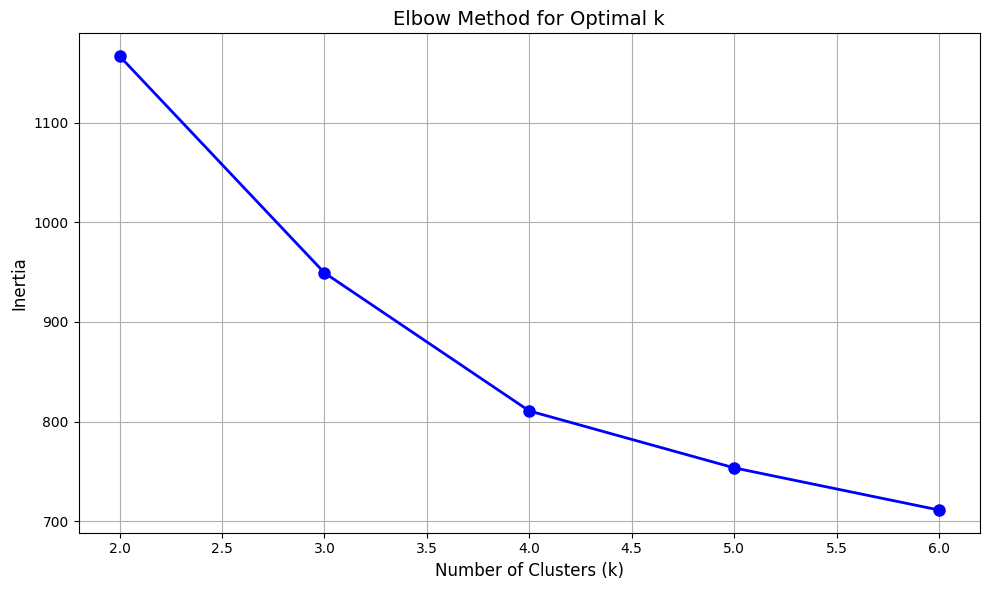

In [29]:
# Plot 1: Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
# minimum DB index is at clusters=4
db_scores

[np.float64(1.4568758898574214),
 np.float64(1.5247669316924684),
 np.float64(1.4028796356467026),
 np.float64(1.5970248494932475),
 np.float64(1.653860923962787)]

In [33]:
optimal_k = db_scores.index(min(db_scores)) + 2
print(f"\nOptimal number of clusters (based on Davies-Bouldin Index): {optimal_k}")
print(f"Davies-Bouldin Score: {min(db_scores):.4f}")

final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = final_kmeans.fit_predict(features_np)

cluster_profiles = []
for cluster in range(optimal_k):
    cluster_profiles.append(features_np[labels == cluster].mean(axis=0))


Optimal number of clusters (based on Davies-Bouldin Index): 4
Davies-Bouldin Score: 1.4029


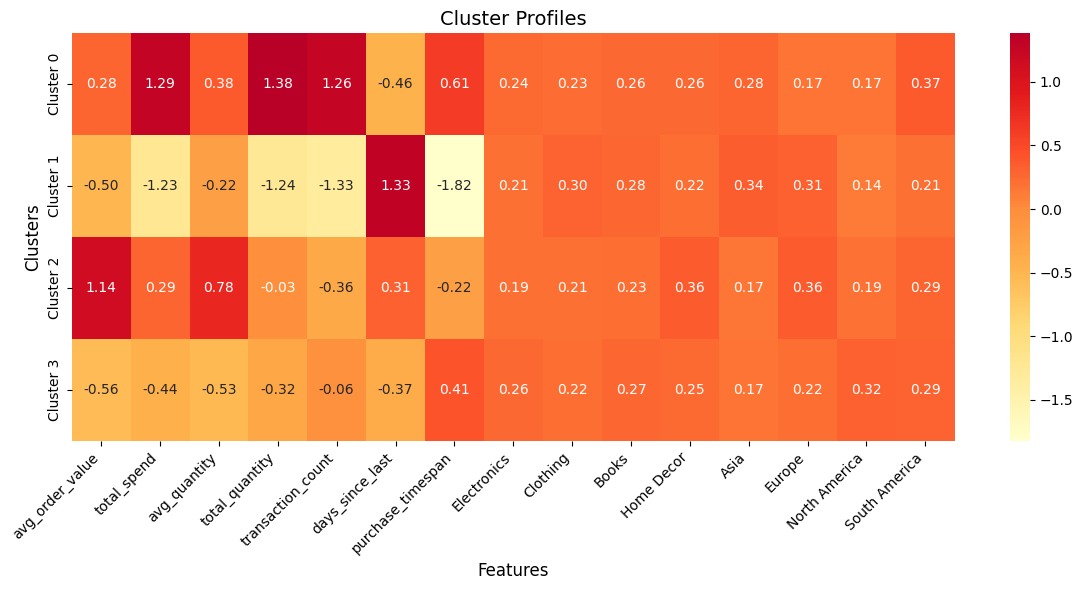

In [34]:
# Plot 2: Cluster profiles heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profiles, 
            xticklabels=feature_names,
            yticklabels=[f'Cluster {i}' for i in range(optimal_k)],
            cmap='YlOrRd',
            center=0,
            annot=True,
            fmt='.2f')
plt.title('Cluster Profiles', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Clusters', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [35]:
customers_df = customers_df[customers_df['CustomerID'] != 'C0180']
# remove the customer with no txns
customers_df['Cluster'] = labels

In [36]:
n_clusters = optimal_k

# analysis of clusters

print("\nCluster sizes:")
for i in range(n_clusters):
    size = (labels == i).sum()
    print(f"Cluster {i}: {size} customers ({(size/len(labels)*100):.1f}%)")

print("\nCluster Characteristics:")
features_np = features.numpy()
for i in range(n_clusters):
    cluster_data = features_np[labels == i]
    print(f"\nCluster {i}:")
    for j, feature in enumerate(feature_names):
        mean_value = cluster_data[:, j].mean()
        print(f"{feature}: {mean_value:.2f}")


Cluster sizes:
Cluster 0: 46 customers (23.1%)
Cluster 1: 29 customers (14.6%)
Cluster 2: 42 customers (21.1%)
Cluster 3: 82 customers (41.2%)

Cluster Characteristics:

Cluster 0:
avg_order_value: 0.28
total_spend: 1.29
avg_quantity: 0.38
total_quantity: 1.38
transaction_count: 1.26
days_since_last: -0.46
purchase_timespan: 0.61
Electronics: 0.24
Clothing: 0.23
Books: 0.26
Home Decor: 0.26
Asia: 0.28
Europe: 0.17
North America: 0.17
South America: 0.37

Cluster 1:
avg_order_value: -0.50
total_spend: -1.23
avg_quantity: -0.22
total_quantity: -1.24
transaction_count: -1.33
days_since_last: 1.33
purchase_timespan: -1.82
Electronics: 0.21
Clothing: 0.30
Books: 0.28
Home Decor: 0.22
Asia: 0.34
Europe: 0.31
North America: 0.14
South America: 0.21

Cluster 2:
avg_order_value: 1.14
total_spend: 0.29
avg_quantity: 0.78
total_quantity: -0.03
transaction_count: -0.36
days_since_last: 0.31
purchase_timespan: -0.22
Electronics: 0.19
Clothing: 0.21
Books: 0.23
Home Decor: 0.36
Asia: 0.17
Europe: 0